## Subtract downstream canyon flow from upstream canyon flow

In [2]:
import cmocean as cmo
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import scipy.io as sio

In [3]:
idalia_land = '#8b7765'
def rotate(x_comp, y_comp, angle):
    '''Input:
        x_comp:: x component of vector
        y_comp:: y component of vector
       angle:: in radians.
       Returns:
       Rotated componets of vector x_rot and y_rot'''
    x_rot = x_comp*np.cos(angle)-(y_comp)*np.sin(angle)
    y_rot = x_comp*np.sin(angle)+(y_comp)*np.cos(angle)
    return(x_rot, y_rot)

def trans_polar(r,th,r0,th0):
    rprime = (r**2+r0**2+2*r*r0*np.cos(th0-th))**0.5
    thprime = np.arccos((r*np.cos(th)+r0*np.cos(th0))/rprime)
    return(rprime,thprime)

def get_field(varname, filepath):
    '''
    file:: str, path to file
    name:: str, variable name (eg 'typevector_filtered', 'velocity_magnitude', 'x','y','u_filtered', 'v_filtered', etc.)
    '''
    mat = sio.loadmat(filepath, squeeze_me=True)
    var = mat[varname]
    return(var)

def get_mask(filepath, fr=0):
    '''Get the mask from a PIV mat file.'''
    mat = sio.loadmat(filepath, squeeze_me=True)
    mask_PIV = np.ma.masked_values(mat['typevector_filtered'][0],0)
    mask = np.ma.getmask(mask_PIV)
    return(mask)

def get_insert_bathy(angle, H = 0.092):
    ''' Get the bathymetry of the canyon insert and x,y coordinates rotated by an angle
    
    INPUT
    angle:: float, angle in radians, positive angle rotates counterclockwise
    H:: float, max depth of water column in meters
    
    RETURNS
    xIns_rot, yIns_rot, x and y coordinates rotated by angle (2D arrays)
    depth_ins, 2D array with depth values'''
    
    insert_file = '/ocean/kramosmu/Building_canyon/BuildCanyon/Bathymetry/tank/BathyInsert03.nc'
    H = 0.092 # m, max water level

    with Dataset(insert_file, 'r') as nbl:
        Xins = nbl.variables['X'][:]
        Yins = nbl.variables['Y'][:]
        depth_ins = (nbl.variables['Bathymetry'][:])-H

    xIns_rot = Xins*np.cos(angle)-(Yins)*np.sin(angle)
    yIns_rot = Xins*np.sin(angle)+(Yins)*np.cos(angle)
    return(xIns_rot, yIns_rot, depth_ins)

def get_plot_data(fr, filepath, angle, mask):
    x_orig = get_field('x', filepath) #(fr,y,x)
    y_orig = -get_field('y', filepath)
    x,y = rotate(x_orig, y_orig, angle)

    u_orig = get_field('u_filtered', filepath) #(fr,y,x)
    v_orig = -get_field('v_filtered', filepath)
    u,v = rotate(u_orig, v_orig, angle)

    spd = get_field('velocity_magnitude', filepath) #(fr,y,x)
    x_ma = 100*np.ma.masked_array(x[fr], mask=mask)
    y_ma = 100*np.ma.masked_array(y[fr], mask=mask)
    u_ma = 100*np.ma.masked_array(u[fr], mask=mask)
    v_ma = 100*np.ma.masked_array(v[fr], mask=mask)
    spd_ma =100* np.ma.masked_array(spd[fr],mask=mask)

    U = u_ma / np.sqrt(u_ma**2 + v_ma**2);
    V = v_ma / np.sqrt(u_ma**2 + v_ma**2);
    return(x_ma,y_ma,u_ma,v_ma,spd_ma,U,V)

def get_plot_data_mean(fr_slice, filepath, angle, mask):
    x_orig = get_field('x', filepath) #(fr_slice,y,x)
    y_orig = -get_field('y', filepath)
    x,y = rotate(x_orig, y_orig, angle)

    u_orig = get_field('u_filtered', filepath) #(fr_slice,y,x)
    v_orig = -get_field('v_filtered', filepath)
    u,v = rotate(u_orig, v_orig, angle)

    spd = get_field('velocity_magnitude', filepath) #(fr_slice,y,x)
     
    x_ma = 100*np.ma.masked_array(np.mean(x[fr_slice],0), mask=mask)
    y_ma = 100*np.ma.masked_array(np.mean(y[fr_slice],0), mask=mask)
    u_ma = 100*np.ma.masked_array(np.mean(u[fr_slice],0), mask=mask)
    v_ma = 100*np.ma.masked_array(np.mean(v[fr_slice],0), mask=mask)
    spd_ma =100*np.ma.masked_array(np.mean(spd[fr_slice],0),mask=mask)
    
    U = u_ma / np.sqrt(u_ma**2 + v_ma**2);
    V = v_ma / np.sqrt(u_ma**2 + v_ma**2);
    return(x_ma,y_ma,u_ma,v_ma,spd_ma,U,V)

In [4]:
# Set file paths
filepath1 = '../exp_18aug19/frames/run02/T11_run02_PIV.mat'
filepath2 = '../exp_18aug19/frames/run03/T12_run03_PIV.mat'

In [5]:
# get masks variables shape is (fr,y,x)

mask1 = get_mask(filepath1) # (y,x)
mask2 = get_mask(filepath2) # (y,x)

In [6]:
angle = 0*np.pi/180  # rot angle piv output

TypeError: Input z must be a 2D array.

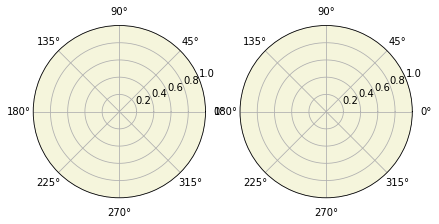

In [14]:
# normalized quiver
max_spd = 0.5
min_spd = -0.5
cbar_ticks = [-0.5,-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4,0.5]

nt = 25
for fr in range(200,225,nt):
    fig = plt.figure(figsize=(10.5,5))
    ax0 = fig.add_subplot(131, projection='polar')
    ax1 = fig.add_subplot(132, projection='polar')
   
    ax0.set_facecolor('beige')
    ax1.set_facecolor('beige')
    
    #frame data
    x_ma1,y_ma1,u_ma1,v_ma1,spd_ma1,U1,V1 = get_plot_data_mean(slice(fr,fr+nt), filepath1, angle, mask1)
    #x_ma2,y_ma2,u_ma2,v_ma2,spd_ma2,U2,V2 = get_plot_data_mean(slice(fr,fr+nt), filepath2, angle, mask2)
    
    r1 = ((x_ma1-12)**2+(y_ma1+23)**2)**0.5
    th1 = np.arctan((y_ma1+23)/(x_ma1-12))
    ur1 = (np.cos(th1)*u_ma1)+(np.sin(th1)*v_ma1)
    uth1 = ((r1*np.cos(th1)*v_ma1)-(r1*np.sin(th1)*u_ma1))/(r1**2)
    
    angle_half = 40*np.pi/180
    th_ups = np.ma.greater_equal(th1,angle_half)
    r_ups = r1[th1>angle_half]
    ur1_ups = ur1[th1>angle_half]
    #r2 = ((x_ma2-12)**2+(y_ma2+23)**2)**0.5
    #th2 = np.arctan((y_ma2+23)/(x_ma2-12))
    #ur2 = (np.cos(th2)*u_ma2)+(np.sin(th2)*v_ma2)
    #uth2 = ((r2*np.cos(th2)*v_ma2)-(r2*np.sin(th2)*u_ma2))/(r2**2)
    
    
    # plot data 1
    cf = ax0.contourf(th_ups,r_ups,ur1_ups,30,
                      cmap=cmo.cm.curl, 
                      vmin=min_spd, vmax=max_spd) # pcolormesh does not work with masked arrays
    cbar_ax = fig.add_axes([0.68, 0.25, 0.016, 0.55])
    cb = plt.colorbar(cf, cax=cbar_ax, ticks=cbar_ticks,format='%.1f')
    cb.ax.yaxis.set_tick_params(pad=1)
    cb.set_label('Radial velocity / cms$^{-1}$')
    
    qv = ax0.quiver(th1[::2,::2],r1[::2,::2],
                    U1[::2,::2],V1[::2,::2],scale=30, 
                    color='k', units='width',pivot='middle')

    # plot data 2
#     cf = ax1.contourf(th2,r2,ur2,30,
#                       cmap=cmo.cm.curl, 
#                       vmin=min_spd, vmax=max_spd) # pcolormesh does not work with masked arrays
    
#     qv = ax1.quiver(th2[::2,::2],r2[::2,::2],
#                     U2[::2,::2],V2[::2,::2],scale=30, 
#                     color='k', units='width',pivot='middle')

    ax0.text(0.2,1.15,'T11 Depth = 3.0 cm',transform=ax0.transAxes)
    ax1.text(0.2,1.15,'T12 Depth = 3.0 cm',transform=ax1.transAxes)
    ax0.text(0.0,1.3,'Mean field between %1.1f-%1.1f s' %(fr/5,(fr+nt)/5), 
             transform=ax0.transAxes)
    ax0.set_ylabel('cm')
    ax0.set_rlim(0,22)
    ax1.set_rlim(0,22)
    ax0.set_thetalim(0*np.pi/180,90*np.pi/180)
    ax1.set_thetalim(0*np.pi/180,90*np.pi/180)
    plt.savefig('T11_T12_mean_ur_polar_fr%d.pdf' %fr, fmt='pdf')

In [35]:
angle_half = 40*np.pi/180
th_ups = np.where(th1>angle_half, th1, np.nan)

nanmask = np.isnan(th_ups)
r_ups = r1*nanmask
ur1_ups = ur1*nanmask

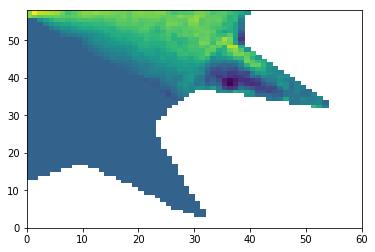

In [37]:
cb = plt.pcolor(ur1_ups)
#plt.colorbar(cb)

In [24]:
np.where(x < 5, x, -1)

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [True, False, False, ..., --, --, --],
        [False, False, False, ..., --, --, --],
        [False, False, False, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],
  fill_value=True)